# A Rapid Introuction to Bayesian Modeling

This brief presentation will use a published case study to examine why Bayesian modeling is useful and how a Bayesian perspective informs data analysis.
Statistics is hard!
If this talk is successful in getting you interested in Bayesian analysis, you should learn more theory (see last slide) before diving into software.

* [James Doss-Gollin](https://jamesdossgollin.me)
* 2020-07-10

In [1]:
# import required packages
import arviz as az
import matplotlib.pyplot as plt # plotting
import numpy as np # numeric data
import pandas as pd # standard for reading in tabular data
from scipy.stats import genextreme as gev
import xarray as xr # for gridded data -- I use whenever possible, it's awesome]

In [2]:
# import pystan and a function to cache stan models to avoid recompilation
import pystan
import pickle
from hashlib import md5

def StanModel_cache(filename: str, model_name: str="", **kwargs):
    """Use just as you would `stan`"""
    with open(filename) as file:
        model_code = file.read()
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    cache_fn = f'cached-{model_name}-{code_hash}.pkl'
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [3]:
# read in data and create an xarray dataset with the areas and floods
areas = pd.read_table("areas.txt", names=["area"]).to_xarray().rename({"index": "site"})["area"]
ann_max_flood = pd.read_table("annmax.txt", names=[f"site_{i}" for i in range(20)], delim_whitespace=True)
ann_max_flood = xr.DataArray(
    ann_max_flood.T,
    coords = {
        "site": np.arange(ann_max_flood.shape[1]),
        "year": np.arange(ann_max_flood.shape[0]),
    },
    dims=["site", "year"]
)
flood_dat = xr.Dataset({"ann_max_flood": ann_max_flood, "area": areas})
n_obs = (1 - flood_dat.isnull()["ann_max_flood"]).sum(dim="year")
flood_dat["site"] = np.arange(len(flood_dat["site"])) + 1
flood_dat

<xarray.Dataset>
Dimensions:        (site: 20, year: 75)
Coordinates:
  * site           (site) int64 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
  * year           (year) int64 0 1 2 3 4 5 6 7 8 ... 66 67 68 69 70 71 72 73 74
Data variables:
    ann_max_flood  (site, year) float64 nan nan nan nan ... 86.12 92.56 342.4
    area           (site) float64 1.61e+04 162.0 2.42e+04 ... 77.4 1.16e+03

## Motivation: Why Bayesian

Bayesian Decision Theory: given an action space $\mathcal{A}$, state space $\mathcal{S}$, reward function (equivalently objective, cost, loss, etc) $R$, the expected reward for taking action $a \in \mathcal{A}$ is
$$\mathbb{E}[R | a] = \int_\mathcal{S} R(a, s)p(s) ds$$
allowing decision maker to select the best action
$$a^* := \arg \max_{a \in \mathcal{A}} \mathbb{E}[R | a]$$
A key point is that:
$$\mathbb{E}_s[R | a] \neq R(\mathbb{E}[s], a)$$
so we **need to fully represent our uncertainty**

## Example: Floods in Brazil

> Lima, C. H. R., Lall, U., Troy, T., & Devineni, N. (2016). A hierarchical Bayesian GEV model for improving local and regional flood quantile estimates. Journal of Hydrology, 541, 816–823. https://doi.org/10.1016/j.jhydrol.2016.07.042

We want to do flood frequency analysis in a single river basin
<div>
<img src="lima-fig-1.png" width="300"/>
</div>

Quick look at data:

1. Data is sparse -- lots of missing observations
2. Large floods register at most sites

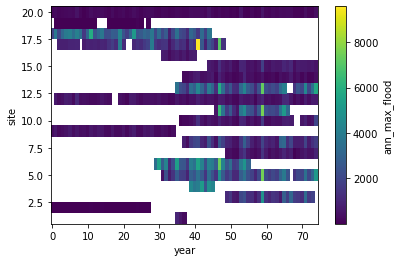

In [4]:
flood_dat["ann_max_flood"].plot()
plt.show()

## Our goal

1. pool information across time and space to get accurate return period information at each site
2. transparently and credibly represent the uncertainty in these parameters (eg, site 0 should have very large uncertainty!)

How would you model this?

We're going to use a Bayesian hierarchical model.

## What is Bayesian statistics?

Bayesian statistics is all about **conditional probability!**

We typically want to conduct inference on the parameters $\theta$ of some model.
To do this we first need to write down a **joint probability model.**

Key insight:
$$ p(\theta, y) = p(\theta) p(y | \theta). $$
The terms on the right hand side of the equation are referred to as the prior and the likelihood functions, respectively.

## Bayes rule

Bayes rule relates joint and conditional probabilities:
$$
p(\theta | y) = \frac{p(\theta, y)}{p(y)}
$$
adding in the term from the previous slide
$$
p(\theta | y) = \frac{p(y | \theta) p(\theta)}{p(y)}
$$
for many problems, $p(\theta | y)$ doesn't depend on $p(y)$, so we can write
$$
p(\theta | y) \propto p(y | \theta) p(\theta)
$$
We call $p(\theta | y)$ the **posterior** distribution.

## Hierarchical models

> Many statistical applications involve multiple parameters that can be regarded as related or connected in some way by the structure of the problem, implying that a joint probability model for these parameters should reflect their dependence.
_(BDA3 p. 101)_

If we have some "hyperparameters" $\phi$ on which $\theta$ depend, then we can go a step farther:
$$
p(\phi, \theta) = p(\phi) p(\theta | \phi)
$$
And so the posterior distribution of is
$$
p(\phi, \theta | y) = p(\phi) p(\theta | \phi) p(y | \theta)
$$

## Lima _et. al_ model

Assume that local floods $Q$ in year $i$ at site $j$ follow a stationary GEV distribution
$$ Q_{i,j} \sim g(\mu_j, \sigma_j, \xi_j) $$
The data model assumes that $\mu_j$ and $\sigma_j$ depend on on catchment area $A_j$:
$$
\begin{align}
\log \mu_j &\sim \mathcal{N} \left( \alpha_1 + \alpha_2 \log A_j, \tau_\mu^2 \right) \\
\log \sigma_j &\sim \mathcal{N} \left( \beta_1 + \beta_2 \log A_j, \tau_\sigma^2 \right) \\
\xi_j &\sim \mathcal{N} \left( \overline{\xi}, \tau_\xi^2 \right)
\end{align}
$$
This is called a "hierarchical" or "partial pooling" model (*why?*)

Here the $Q_{i,j}$ the data ($y$ in earlier notation), the $\mu_j, \sigma_j, \xi_j$ are the parameters ($\theta$) and the hyperparameters $\alpha_1, \alpha_2, \beta_1, \beta_2, \overline{xi}, \tau_\mu, \tau_\sigma, \tau_\xi$ ($\theta$).

## Key assumptions

* Floods follow stationary GEV
* Floods are IID in space and time (no clustering!)
* Data missing at random

## Priors on hyperparameters

Lima _et al_ use uniform priors.
This places lots of weight on extremely implausible regions of the probability space.

We should use _weakly informative_ priors -- these should "capture what we know about rivers, but not the data we've collected about _this_ river".
A good way to check priors is to use your prior model to simulate fake data.
If it doesn't look completely absurd, you're probably OK.

The paper claims that they use uninformative priors.
However, that's not born out in their code -- instead we'll use weakly informative priors.

## Missing data

1. Missing data _don't pose a mechanistic challenge for our problem._ For places where we have very little information, we will rely more heavily on our model: $\log \mu_j \approx \alpha_1 + \alpha_2 \log A_j$.
2. That said, an analysis _should model the data collection process_. See BDA3 Chapter 8.

We'll assume that data are "missing at random."
This means that, the probability of data being observed (or missing) does not depend on the $y$.
In our case this clearly depends on time, but we have a stationary model -- we're going to pretend to believe in it completely!

## Stan

Stan is

* a modeling language for specifying Bayesian models (like the one above)
* a program that conducts inference on these models using Markov Chain Monte Carlo

Why [MCMC](https://chi-feng.github.io/mcmc-demo/app.html#NaiveNUTS,banana)?

* we can't compute our distributions analytically!
* we can't even compute them numerically
* however, thanks to cool math we _can_ sample from them!

We will approximate $p(\theta, \phi | y)$ by drawing many "Monte Carlo" samples of $\{\theta, \phi \}$ (using stan!).

## Compilation

Stan is a compiled language; it's slow to compile but fast to run.
The compiler will check the code for syntax errors, although it doesn't catch everything.
Then we can re-use the compiled model.

In [5]:
stan_model = StanModel_cache("lima.stan", model_name="lima-2016")

Using cached StanModel


In [6]:
print(stan_model.model_code)

functions{
    real gev_lpdf(real y, real mu, real sigma, real xi) {
        real t;
        real lp;
        t = xi==0 ? exp((mu - y) / sigma) : pow(1 + xi * ((y - mu ) / sigma), -1 / xi);
        lp = -log(sigma) + (xi + 1) * log(t) - t;
        return lp;
    }
    real gev_rng(real mu, real sigma, real xi){
        real p;
        real z;
        real epsilon;
        p = uniform_rng(0, 1);
        epsilon = 0.0001;
        z = fabs(xi) < epsilon ? -log(-log(p)): expm1(-xi * log(-log(p))) / xi;
        return mu + sigma * z;
    }
}

data {
    int<lower=0> J; // number of sites
    int<lower=0> N; // number of observations
    real<lower=0> log_area[J]; // area of each watershed
    real flood[N]; // the annual-maximum floods
    int site[N]; // the index of each data point
    // pass priors as data to avoid recompiling
    real alpha_1_std;
    real alpha_2_std;
    real beta_1_std;
    real beta_2_std;
    real xi_bar_std;
    real tau_mu_std;
    real tau_sigma_std;
    real t

## Data

We need to pass the data to Stan in a format it understands (see the `data` block)

In [7]:
non_missing_data = flood_dat.to_dataframe().reset_index().dropna()[["site", "ann_max_flood"]]
log_area = np.log(flood_dat["area"])
log_area = log_area - np.min(log_area)
stan_data = {
    "J": len(flood_dat["site"]),
    "N": len(non_missing_data),
    "log_area": np.array(log_area),
    "flood": np.array(non_missing_data["ann_max_flood"]),
    "site": np.array(non_missing_data["site"]),
    "alpha_1_std": 0.5,
    "alpha_2_std": 0.5,
    "beta_1_std": 0.5,
    "beta_2_std": 0.5,
    "xi_bar_std": 0.5,
    "tau_mu_std": 0.5,
    "tau_sigma_std": 0.5,
    "tau_xi_std": 0.5,
}

## Fitting the model

This model takes about 45 seconds to run on my computer:

In [8]:
def get_inits():
    return {
        'mu': np.repeat(100, stan_data["J"]),
        'sigma': np.repeat(100, stan_data["J"]),
        'xi': np.repeat(0.1, stan_data["J"]),
        "alpha_1": stan_data["alpha_1_std"],
        "alpha_2": stan_data["alpha_2_std"],
        "beta_1": stan_data["beta_1_std"],
        "beta_2": stan_data["beta_2_std"],
        "xi_bar": stan_data["xi_bar_std"],
        "tau_mu": stan_data["tau_mu_std"],
        "tau_sigma": stan_data["tau_sigma_std"],
        "tau_xi": stan_data["tau_xi_std"],
    }

In [9]:
fname = "posterior.nc"
try:
    az_data = az.from_netcdf(fname)
except FileNotFoundError:
    fit = stan_model.sampling(data=stan_data, iter=5000, chains=4, warmup=1000, init=get_inits)
    az_data = az.from_pystan(
        posterior=fit,
        posterior_predictive="y_hat",
        observed_data=["flood"],
        log_likelihood={"flood": "log_lik"},
        coords={"site": flood_dat["site"]},
        dims={
            "mu": ["site"],
            "sigma": ["site"],
            "xi": ["site"],
            "y_hat": ["obs"],
            "flood": ["obs"],
        },
    )
    
    az_data.to_netcdf(fname)

In [10]:
az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],595.023,140.351,326.635,856.530,1.030,0.728,18577.0,18577.0,17843.0,10777.0,1.0
mu[1],12.906,1.756,9.678,16.263,0.014,0.010,15140.0,15140.0,15030.0,11506.0,1.0
mu[2],1191.436,126.803,958.371,1434.289,0.896,0.633,20034.0,20034.0,19778.0,11747.0,1.0
mu[3],3575.507,462.109,2699.826,4444.960,3.621,2.560,16288.0,16288.0,17165.0,9605.0,1.0
mu[4],1787.956,148.938,1523.037,2077.553,1.033,0.731,20772.0,20772.0,20661.0,12134.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta_2,0.807,0.048,0.719,0.897,0.000,0.000,9673.0,9459.0,10094.0,9198.0,1.0
xi_bar,0.130,0.050,0.036,0.225,0.000,0.000,10689.0,10689.0,10698.0,11754.0,1.0
tau_mu,0.343,0.077,0.211,0.485,0.001,0.001,10129.0,9715.0,10762.0,10749.0,1.0
tau_sigma,0.344,0.082,0.202,0.494,0.001,0.001,8612.0,8604.0,8681.0,10874.0,1.0


## Visualization

We can use the `arviz` package to visualize our model fit.
Visualization is a critical component of a Robust Bayesian Workflow

* Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389–402. https://doi.org/10.1111/rssa.12378
* [M Betancourt: Towards a Principled Bayesian Workflow](https://github.com/betanalpha/jupyter_case_studies/blob/master/principled_bayesian_workflow/principled_bayesian_workflow.ipynb)

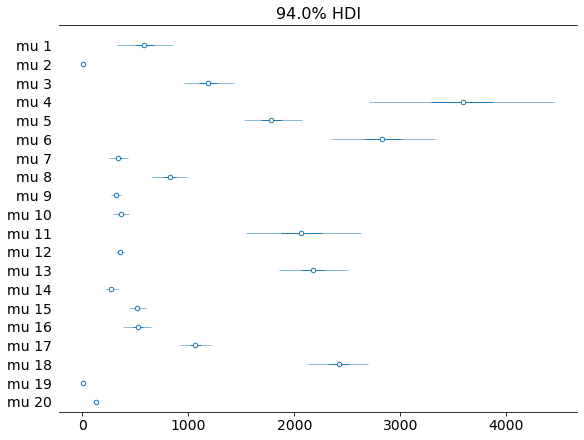

In [11]:
az.plot_forest(
    az_data, combined=True, hdi_prob=0.94, var_names=["mu"],
    kind="forestplot", linewidth=0.5, ridgeplot_overlap=0.2, figsize=(8, 6)
)
plt.show()

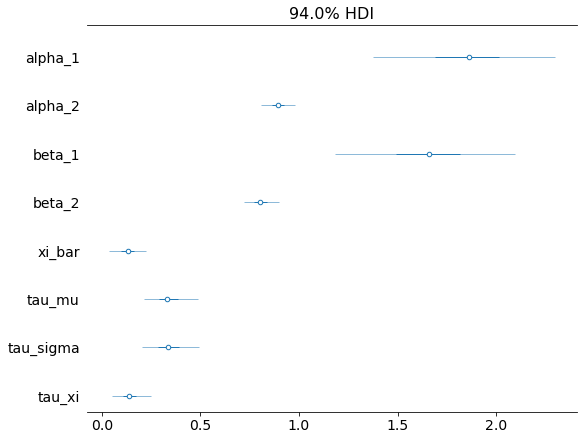

In [12]:
az.plot_forest(
    az_data, combined=True, hdi_prob=0.94,
    var_names=["alpha_1", "alpha_2", "beta_1", "beta_2", "xi_bar", "tau_mu", "tau_sigma", "tau_xi"],
    kind="forestplot", linewidth=0.5, ridgeplot_overlap=0.2, figsize=(8, 6)
)
plt.show()

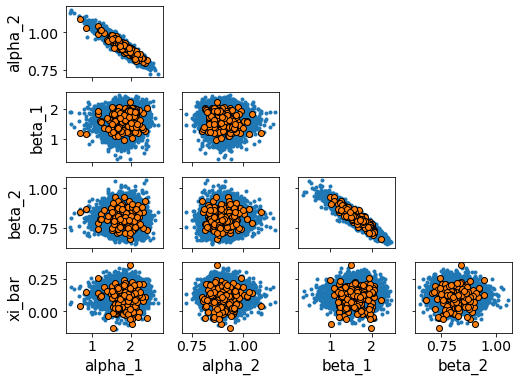

In [13]:
az.plot_pair(
    az_data, var_names=["alpha_1", "alpha_2", "beta_1", "beta_2", "xi_bar"],
    divergences=True, figsize=(8, 6)
)
plt.show()

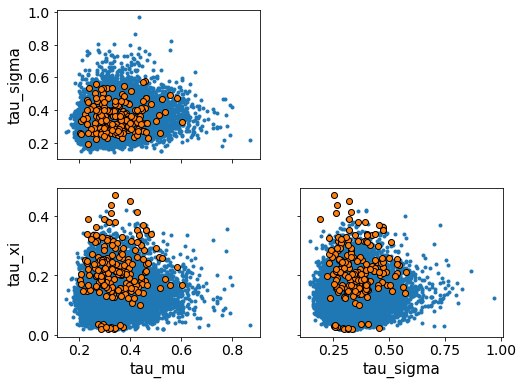

In [14]:
az.plot_pair(
    az_data, var_names=["tau_mu", "tau_sigma", "tau_xi"],
    divergences=True, figsize=(8, 6)
)
plt.show()


More sophisticated diagnostics:

> [BayesPlot R package](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html): Informally, the energy diagnostic for HMC quantifies the heaviness of the tails of the posterior distribution. The two histograms ideally look the same [(Betancourt, 2017)](https://arxiv.org/abs/1701.02434) 


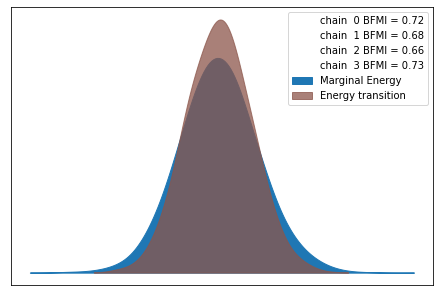

In [15]:
az.plot_energy(az_data)
plt.show()

## Posterior predictive checks

Premise:

1. If our model is good, then simulations from our model should look like our data in dimensions that we care about
2. An iterative cycle of build -> check helps us improve our model over time

Since this is a quick test case, we're just going to run one posterior predictive check.
Specifically, let's compare the CDF distribution of simulated floods (from our GEV model, using the calibrated parameters and simulating at the same vector of sites as our input data) with observed.

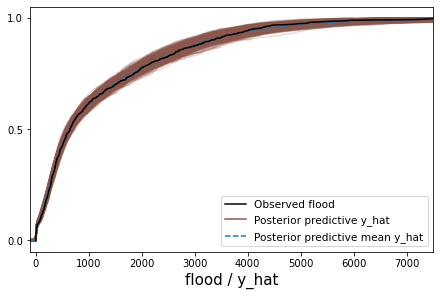

In [16]:
az.plot_ppc(az_data, kind="cumulative", num_pp_samples=1000, data_pairs={"flood": "y_hat"})
plt.xlim([-100, 7500])
plt.show()

## More Checks

In a more rigorous example, we would run additional simulation-based checks that make use of "test statistics" that map the estimated parameters $p(\theta | y)$ to $\mathbb{R}$

Some of these would require us to add to the `generated quantities` block

* calculate the CDF at each site and compare to observations
* with what frequency are the estimated 5, 10, 100 year floods at each site exceeded?

## Summary

Bayesian statistics means our goal is a joint probability distribution

1. Write down a model using conditional distributions (in Stan)
1. Sample from the posterior joint distribution $p(\theta | y)$ using MCMC
1. Check our model using quantitative, numerical summaries

Advantages

* combine data from different sources
* transparently and honestly quantify uncertainty
* make assumptions clear
* force yourself to write down and think about the full model

## Learn More

* [Stan Docs](https://mc-stan.org/)
* [PyStan Docs](http://pystan.readthedocs.io/)
* Gelman [BDA3](http://stat.columbia.edu/~gelman/book/BDA3.pdf) is the canonical textbook and used in graduate classes
* [Michael Betancourt](https://betanalpha.github.io/writing/) case studies
* The Stan developers publish a [guide to priors](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) that you should read if you build a Bayesian model
* A good text on (complicated!) Bayesian models for space-time data. Cressie, N. A. C., & Wikle, C. K. (2011). Statistics for spatio-temporal data.